In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import numba as nb

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping, StochasticWeightAveraging
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, log_loss
from sklearn.utils import shuffle


from xgboost import XGBClassifier

from glob import glob
from tqdm import tqdm
import itertools 
import time

from typing import Optional, List, Union
import logging
from IPython.utils import io

import spect

In [2]:
import imp
imp.reload(spect)

<module 'spect' from '/exports/csce/datastore/geos/users/s1205782/Projects/spect/notebooks/spect.py'>

# **Load and proprocess data**

In [ ]:
bins = np.arange(0, 1350, 50)
ds_bin = spect.get_binned_data(bins=bins)

100%|███████████████████████████████████████████████████████████████████████████████| 1570/1570 [04:46<00:00,  5.48it/s]


In [ ]:
ds_bin

<xarray.Dataset>
Dimensions:          (sample_id: 1570, mz: 101, temp_bins: 26, species: 10)
Coordinates:
  * sample_id        (sample_id) object 'S0000' 'S0001' ... 'S1568' 'S1569'
  * mz               (mz) int64 0 1 2 3 4 5 6 7 8 ... 93 94 95 96 97 98 99 100
  * temp_bins        (temp_bins) object (0, 50] (50, 100] ... (1250, 1300]
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    abundance        (sample_id, temp_bins, mz) float64 5.543e-11 ... nan
    time             (sample_id, temp_bins) float64 61.56 266.8 ... nan nan
    temp             (sample_id, temp_bins) float64 40.9 74.9 122.9 ... nan nan
    labels           (sample_id, species) float64 0.0 0.0 0.0 ... nan nan nan
    split            (sample_id) object 'train' 'train' ... 'test' 'test'
    instrument_type  (sample_id) object 'commercial' ... 'sam_testbed'

In [ ]:
ds_scale = ds_bin['abundance'].mean(dim=('temp_bins', 'mz')).groupby(ds_bin.instrument_type).mean()
missing_fill = np.nan

def preprocess(ds, drop_he=False, rebase=False, maxscale=True, scale_int=True, log_scale=False):
    ds_pro = ds
    ds_pro['integrated_abundance'] = ds_pro['abundance'].mean(dim='temp_bins')
    if scale_int:
        ds_pro['integrated_abundance'] = (
            (ds_pro['integrated_abundance'].groupby(ds.instrument_type)/ds_scale)
            .drop('instrument_type')
        )
    ds_pro['features'] = ds_pro['abundance']
    if rebase:
        ds_pro['features'] = ds_pro.features - ds_pro.features.min(dim=('temp_bins'))
    if drop_he:
        ds_pro = ds_pro.drop_sel(mz=4)
    if maxscale:
        ds_pro['features'] = ds_pro.features/ds_pro.features.max(dim=('temp_bins', 'mz'))
    if log_scale:
        ds_pro['features'] = np.log10(ds_pro['features'].clip(1e-4,None))
        ds_pro['integrated_abundance'] = np.log10(ds_pro['integrated_abundance'].clip(1e-4,None))
    ds_pro = ds_pro.fillna(missing_fill)
    return ds_pro

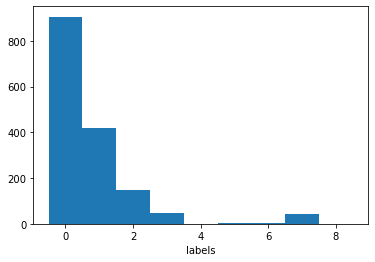

In [ ]:
clip_n=9
ds_bin.labels.sum(dim='species').clip(0, clip_n).plot.hist(bins = np.arange(0,clip_n+1)-.5)
plt.show()

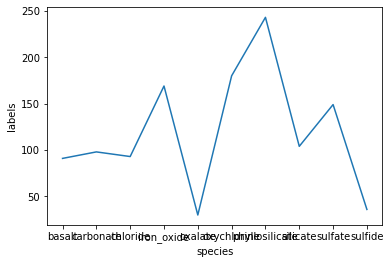

In [ ]:
ds_bin.labels.sum(dim='sample_id').plot()

In [ ]:
species_positive = ds_bin.where(
    (ds_bin.labels.sel(species='carbonate'))==1, #+
    #ds_bin.labels.sum(dim='species')>0)==2,
    drop=True)

In [ ]:
species_positive

<xarray.Dataset>
Dimensions:          (sample_id: 98, temp_bins: 26, mz: 101, species: 10)
Coordinates:
  * sample_id        (sample_id) object 'S0001' 'S0003' ... 'S0747' 'S0755'
  * mz               (mz) int64 0 1 2 3 4 5 6 7 8 ... 93 94 95 96 97 98 99 100
  * temp_bins        (temp_bins) object (0, 50] (50, 100] ... (1250, 1300]
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    abundance        (sample_id, temp_bins, mz) float64 nan 5.377e-10 ... nan
    time             (sample_id, temp_bins) float64 845.7 993.1 ... nan nan
    temp             (sample_id, temp_bins) float64 24.5 73.93 125.6 ... nan nan
    labels           (sample_id, species) float64 0.0 1.0 0.0 ... 0.0 1.0 0.0
    split            (sample_id) object 'train' 'train' ... 'train' 'train'
    instrument_type  (sample_id) object 'commercial' ... 'sam_testbed'

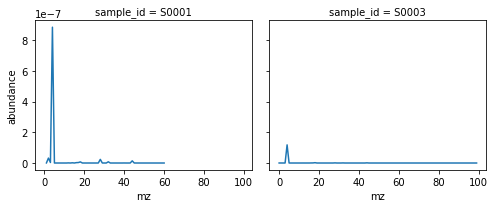

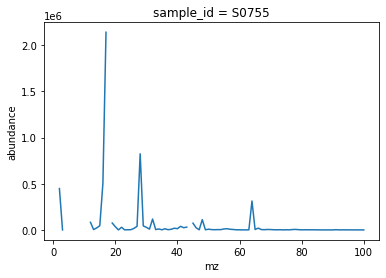

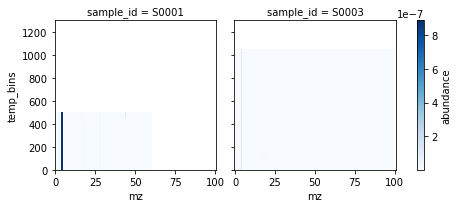

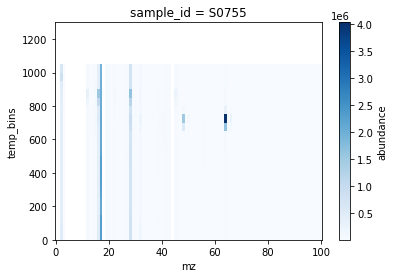

In [ ]:
import matplotlib.colors as colors
norm=colors.LogNorm(vmin=0)

n=2
#norm=colors.Normalize(vmin=.01, vmax=1)
for s in np.unique(ds_bin.instrument_type):
    x = species_positive.abundance\
            .where(ds_bin.instrument_type==s, drop=True) \
            .isel(sample_id=slice(0,n)) \
            .mean(dim='temp_bins')
    if len(x.sample_id)==0:
        continue
    elif len(x.sample_id)==1:
        x.plot()
    else:
        x.plot(col="sample_id")#, col_wrap=4)#, norm=norm, cmap='Blues')            
    plt.show()

for s in np.unique(ds_bin.instrument_type):
    x = species_positive.abundance\
        .where(ds_bin.instrument_type==s, drop=True) \
        .isel(sample_id=slice(0,n))
    
    if len(x.sample_id)==0:
        continue
    elif len(x.sample_id)==1:
        x.plot(cmap='Blues')
    else:
        x.plot(col="sample_id",cmap='Blues')#, col_wrap=4)#, norm=norm, cmap='Blues')            
    plt.show()


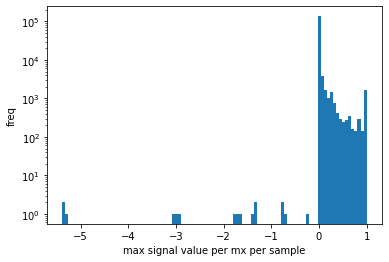

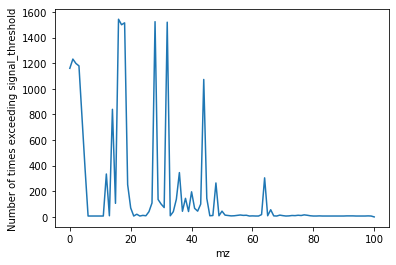

Number of mz with signal_threshold=0.01 and occurence_threshold=1 is : 99


In [ ]:
ds = preprocess(ds_bin, drop_he=True)


(ds.features.max(dim=('temp_bins'))).plot.hist(bins=100);
plt.yscale('log')
plt.xlabel('max signal value per mx per sample')
plt.ylabel('freq')
plt.show()

signal_threshold = 0.01 # 0.01 used for sub
occurence_threshold = 1 # 10 used for sub

x = (ds.features.max(dim=('temp_bins'))>signal_threshold).sum(dim='sample_id')
x.plot()
plt.xlabel('mz')
plt.ylabel(f'Number of times exceeding signal_threshold')
plt.show()
print(f"Number of mz with signal_threshold={signal_threshold} and occurence_threshold={occurence_threshold} is : {(x>occurence_threshold).sum().item()}")

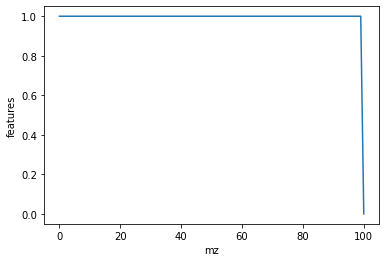

In [ ]:
## get rid of mz which don't have strong signal many times
mz_mask = (ds.features.max(dim=('temp_bins'))>signal_threshold).sum(dim='sample_id') > occurence_threshold
mz_mask = mz_mask.reindex(mz=ds_bin.mz).fillna(True)
mz_mask.plot()

In [ ]:
ds_bin_filt = ds_bin.sel(mz=mz_mask.astype(bool))
ds_bin_filt

<xarray.Dataset>
Dimensions:               (sample_id: 1570, mz: 100, temp_bins: 26, species: 10)
Coordinates:
  * sample_id             (sample_id) object 'S0000' 'S0001' ... 'S1568' 'S1569'
  * mz                    (mz) int64 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
  * temp_bins             (temp_bins) object (0, 50] (50, 100] ... (1250, 1300]
  * species               (species) <U14 'basalt' 'carbonate' ... 'sulfide'
Data variables:
    abundance             (sample_id, temp_bins, mz) float64 5.543e-11 ... nan
    time                  (sample_id, temp_bins) float64 61.56 266.8 ... nan nan
    temp                  (sample_id, temp_bins) float64 40.9 74.9 ... nan nan
    labels                (sample_id, species) float64 0.0 0.0 0.0 ... nan nan
    split                 (sample_id) object 'train' 'train' ... 'test' 'test'
    instrument_type       (sample_id) object 'commercial' ... 'sam_testbed'
    integrated_abundance  (sample_id, mz) float64 0.02868 0.02717 ... nan nan
    features              (sample_id, temp_bins, mz) float64 5.543e-11 ... nan

## Process data

In [ ]:
from skmultilearn.model_selection import iterative_train_test_split


def base2_split(indices, y, splits):
    log2_splits = np.log2(splits)
    assert log2_splits==int(log2_splits)
    if log2_splits==1:
        indices_1, _, indices_2, _ = iterative_train_test_split(indices, y, test_size=0.5)
        return [indices_1, indices_2]
    else:
        indices_1, y_1, indices_2, y_2 = iterative_train_test_split(indices, y, test_size=0.5)
        return base2_split(indices_1, y_1, splits//2)+base2_split(indices_2, y_2, splits//2)

def cross_val_splits(ds, splits, random_seed=None):
    np.random.seed(random_seed)
    y = ds.labels.values
    indices = shuffle(ds.sample_id.values[:,None])
    partitions = base2_split(indices, y, splits=splits)
    ds_train_test = []
    for p in partitions:
        ds_train_test.append((ds.drop_sel(sample_id=p[:,0]), ds.sel(sample_id=p[:,0])))
    return ds_train_test

def cross_val_splitsog(ds, splits, random_seed=None):
    shuffled_ids = shuffle(ds.sample_id.values, random_state=random_seed)
    n = len(shuffled_ids)//splits
    partitions = [shuffled_ids[i*n:(i+1)*n] for i in range(splits)]
    ds_train_test = []
    for p in partitions:
        ds_train_test.append((ds.drop_sel(sample_id=p), ds.sel(sample_id=p)))
    return ds_train_test

### Final dataset

In [ ]:
ds_final = ds_bin_filt.where(ds_bin.split=='train', drop=True)

ds_final

<xarray.Dataset>
Dimensions:               (sample_id: 766, temp_bins: 26, mz: 100, species: 10)
Coordinates:
  * sample_id             (sample_id) object 'S0000' 'S0001' ... 'S0764' 'S0765'
  * mz                    (mz) int64 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
  * temp_bins             (temp_bins) object (0, 50] (50, 100] ... (1250, 1300]
  * species               (species) <U14 'basalt' 'carbonate' ... 'sulfide'
Data variables:
    abundance             (sample_id, temp_bins, mz) float64 5.543e-11 ... nan
    time                  (sample_id, temp_bins) float64 61.56 266.8 ... nan nan
    temp                  (sample_id, temp_bins) float64 40.9 74.9 ... nan nan
    labels                (sample_id, species) float64 0.0 0.0 0.0 ... 0.0 0.0
    split                 (sample_id) object 'train' 'train' ... 'train' 'train'
    instrument_type       (sample_id) object 'commercial' ... 'sam_testbed'
    integrated_abundance  (sample_id, mz) float64 0.02868 0.02717 ... 0.0006179
    features              (sample_id, temp_bins, mz) float64 5.543e-11 ... nan

In [ ]:
def this_preprocess(ds):
    return preprocess(ds, drop_he=False, rebase=False, maxscale=True, scale_int=True, log_scale=False)

# **xgboost**

## Functions

In [ ]:
def mean_and_uncert(random_search):
    i = np.argwhere(random_search.cv_results_["mean_test_score"]==random_search.best_score_).item()
    m = random_search.cv_results_["mean_test_score"][i]
    s = random_search.cv_results_["std_test_score"][i]
    return m,s

def compile_best_score(random_search):
    m,s = mean_and_uncert(random_search)
    return string_uncert(m,s)

def string_uncert(m,s):
    return f"{m:.3f} +- {s:.3f}"

scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

In [36]:
params = dict(
    min_child_weight = 2,
    gamma = .1,
    subsample = 0.9,
    colsample_bytree = 0.9,
    reg_alpha = 0.01,
    max_depth = 6,
    learning_rate = 0.05,
    n_estimators = 500,
    max_delta_step = 1,
    scale_pos_weight = 8,
)

early_stopping_rounds = 20

import sklearn
import dask
from dask.diagnostics import ProgressBar

scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)


@dask.delayed
def fit_and_score(clf, X_train, y_train,  X_val, y_val):
    clf.fit(
        X_train, y_train, 
        eval_set=((X_train, y_train), (X_val, y_val),), 
        early_stopping_rounds=early_stopping_rounds, 
        eval_metric="logloss",
        verbose=0
    )
    s = scorer(clf, X_val, y_val)
    return clf, s
    

def prepare_data_xg(ds):
    
    X = [
        ds.features.stack(dict(z=("temp_bins","mz"))).values, 
        (ds.instrument_type.values=='commercial').astype(float)[:, None],
        ds.integrated_abundance.values,
        ds.time.values,
    ]
    X = np.concatenate(X, axis=1)

    y = ds.labels.values
    return X, y

def train_xgboost(ds_train, ds_val):
    
    X_train, y_train = prepare_data_xg(ds_train)
    X_val, y_val = prepare_data_xg(ds_val)
    
    clf = XGBClassifier(
            n_jobs=20,
            eval_metric='logloss',
            gpu_id=0,
            use_label_encoder=False,
            missing=missing_fill,
            tree_method='exact',
            **params,
    )
    
    models = []
    scores = []
    results = []
    
    for col in range(y_train.shape[1]):
        this_clf = sklearn.base.clone(clf)
        results += [fit_and_score(this_clf, X_train, y_train[:, col],  X_val, y_val[:, col])]
    with ProgressBar(dt=5):
        results = dask.compute(*results, scheduler='threads')
    models = [r[0] for r in results]
    scores = [r[1] for r in results]
    return models, scores

In [37]:
def tprint(m):
    print(f"{time.asctime()} - {m}")

## Run

In [38]:
ds_train_test_splits = cross_val_splits(ds_final, 8, random_seed=317984)

In [39]:
cross_val_results = []
for i, split in enumerate(ds_train_test_splits):
    #tprint(f'Split {i+1} of {len(ds_train_test_splits)}')
    cross_val_results.append(train_xgboost(*split))

[########################################] | 100% Completed |  2min 30.2s
[########################################] | 100% Completed |  1min 40.1s
[########################################] | 100% Completed |  2min  0.2s
[########################################] | 100% Completed |  1min 40.1s
[########################################] | 100% Completed |  2min  0.2s
[########################################] | 100% Completed |  2min  5.2s
[########################################] | 100% Completed |  1min 45.2s
[########################################] | 100% Completed |  2min  5.2s


In [40]:
x = []
for models, scores in cross_val_results:
    x0 = []
    for m in models:
        x0 += [m.feature_importances_]
    x += [x0]
    
x = np.array(x)

In [160]:
def importance_to_ds(importances, scale=False):
    ti = ds.time.shape[1]
    time_importance = importances[-ti:]

    ai = ds.integrated_abundance.shape[1]
    abundance_importance = importances[-(ti+ai):-ti]

    type_importance = importances[-(ti+ai+1):-(ti+ai)]

    feature_importance = importances[:-(ti+ai+1)]
    
    ds_imp = ds.isel(sample_id=0).copy(deep=True)

    ds_imp['instrument_type'] = type_importance.item()

    ds_imp.integrated_abundance.values[:] = abundance_importance
    ds_imp.integrated_abundance.values[:] = abundance_importance
    ds_imp.time.values[:] = time_importance

    da_imp = ds_imp['features'].stack(dict(z=("temp_bins","mz")))
    da_imp.values[:] = feature_importance
    da_imp = da_imp.unstack(dim='z')
    ds_imp['features'] = da_imp

    ds_imp = ds_imp.drop(('split', 'abundance', 'labels', 'temp'))

    scale = max([x for x  in ds_imp.max().values()]).item()
    
    ds_imp.attrs['scale_max'] = scale
    
    return ds_imp

In [180]:
def plot_all_importances(ds):
    fig, axes = plt.subplots(2,2, figsize=(12,8))
    ds.time.plot(ax=axes[0,0])
    ds.integrated_abundance.plot(ax=axes[1,0])
    ds.features.plot(ax=axes[0,1])#, vmin=0, vmax=ds.attrs['scale_max'])
    ds.features.mean(dim='temp_bins').plot(ax=axes[1,1])
    plt.tight_layout()
    print('instrument_type importance: ', ds.instrument_type.item())

instrument_type importance:  0.0


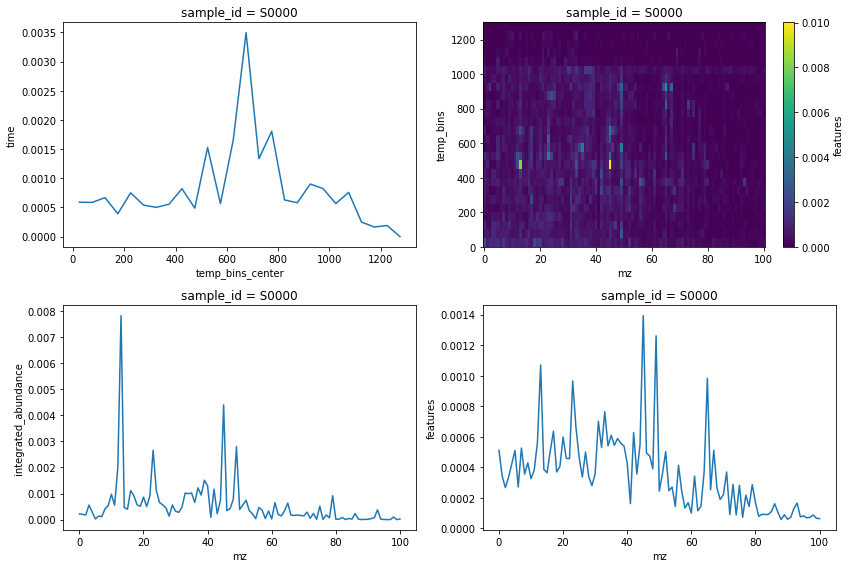

In [181]:
ds_imp = importance_to_ds(x.mean(axis=(0,1)))
plot_all_importances(ds_imp)

instrument_type importance:  0.0


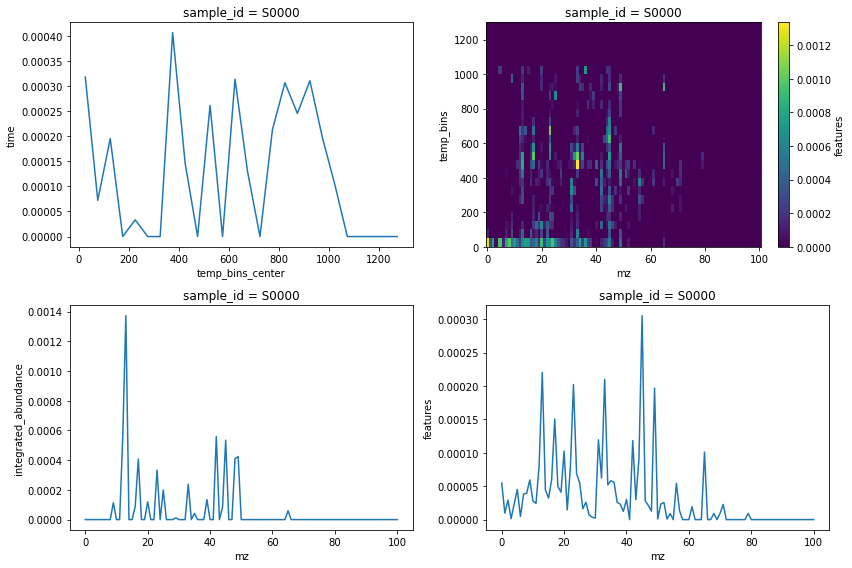

In [182]:
ds_imp = importance_to_ds(np.median(x, axis=(0,1)))
plot_all_importances(ds_imp)

instrument_type importance:  0.0


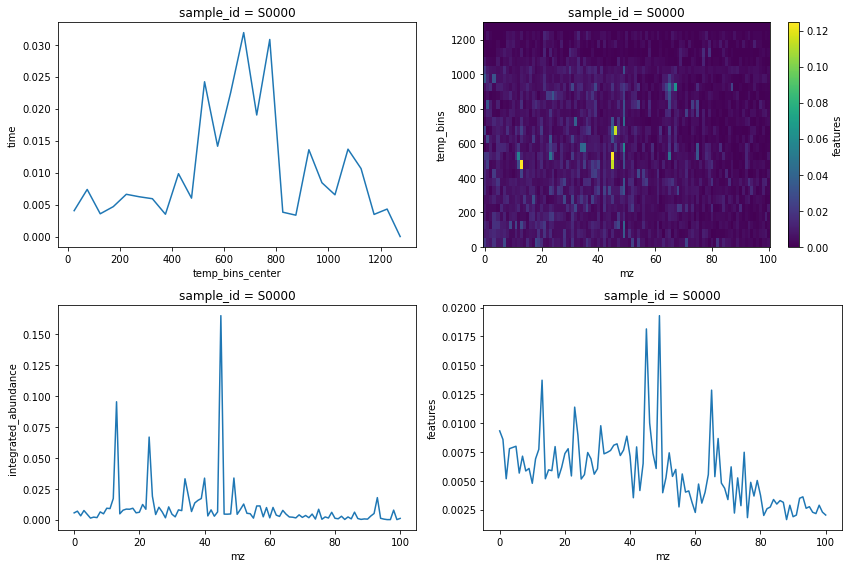

In [183]:
ds_imp = importance_to_ds(x.max(axis=(0,1)))
plot_all_importances(ds_imp)

Probably cut to `mz<=80` and `temp_bins<=1050`

instrument_type importance:  0.0


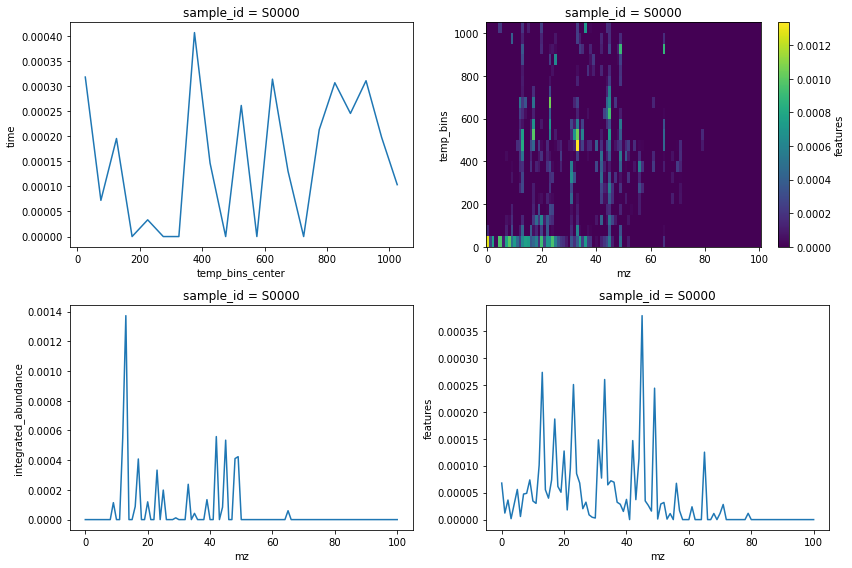

In [184]:
ds_imp = importance_to_ds(np.median(x, axis=(0,1)))
plot_all_importances(ds_imp.sel(temp_bins=slice(0, 1050)))

In [167]:
ds_imp.sel(temp_bins=slice(0, 1000))

<xarray.Dataset>
Dimensions:               (temp_bins: 20, mz: 100, species: 10)
Coordinates:
    sample_id             <U5 'S0000'
  * mz                    (mz) int64 0 1 2 3 5 6 7 8 ... 94 95 96 97 98 99 100
  * temp_bins             (temp_bins) object (0, 50] (50, 100] ... (950, 1000]
  * species               (species) <U14 'basalt' 'carbonate' ... 'sulfide'
Data variables:
    time                  (temp_bins) float64 0.004045 0.007368 ... 0.008418
    instrument_type       float64 0.0
    integrated_abundance  (mz) float64 0.005444 0.006848 ... 0.0 0.0009753
    features              (temp_bins, mz) float64 0.01982 0.009599 ... 0.002305
Attributes:
    scale_max:  0.165080264210701